In [1]:
import numpy as np
from numpy import *
from math import pi
import matplotlib as mpl
from matplotlib import animation
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from time import sleep
from IPython.display import clear_output
from scipy import signal
import scipy as scp

In [2]:
def cenDiff(x,y): #4th order central difference stencil method
    
    if size(x) != size(y): #Check for simmilar size between x and y
        print("x and y not the same size!")
        return
    
    nx = size(x) #Get the number of x values
    dydx = zeros(nx) #Create an array of 0's with a simmilar size to x as stored in nx
    h = 0.001
    
    dydx[0] = (((-3*y[0]) + (4*y[1]) + (-1*y[2])) / (2*h)) / (((-3*x[0]) + (4*x[1]) + (-1*x[2])) / (2*h))
    dydx[1] = (((-3*y[0+1]) + (4*y[1+1]) + (-1*y[2+1])) / (2*h)) / (((-3*x[0+1]) + (4*x[1+1]) + (-1*x[2+1])) / (2*h))
    
    for i in range(2,nx-2):
        dydx[i] = (((y[i-2]) - (8*y[i-1]) + (8*y[i+1]) - (y[i+2])) / (12*h)) / (((x[i-2]) - (8*x[i-1]) + (8*x[i+1]) - (x[i+2])) / (12*h))
    
    dydx[-1] = (((3*y[nx-1]) + (-4*y[nx-2]) + (y[nx-3])) / (2*h)) / (((3*x[nx-1]) + (-4*x[nx-2]) + (x[nx-3])) / (2*h))
    dydx[-2] = (((3*y[nx-1-1]) + (-4*y[nx-2-1]) + (y[nx-3-1])) / (2*h)) / (((3*x[nx-1-1]) + (-4*x[nx-2-1]) + (x[nx-3-1])) / (2*h))
    
    return dydx #Return the dydx list

def dataLoad(path, filename, col1): #Load data, from (path+filename) pull from (col1) columns
    time = loadtxt(path+"/"+filename, usecols=(0), unpack=True)
    outData = loadtxt(path+"/"+filename, usecols=(col1[0], col1[1], col1[2]), unpack=True)
    return(time, outData) #Return (time) and (outData), as an array

def getData2D(time, QzzDat, theta=[np.pi/2], derivType=0):
    #[/] What does this function do?
    #Load in data from a given file, using two coloumns (0,col1).
    #Run it through an equation to extract the gravitational wave (GW) signal.
    #Return GW signal and time as h, t respectively

    #t, Qzz = loadtxt(filename, usecols=(0,col1), unpack=True) #Load in data (0,col1) from file 
    QddotZZ = cenDiff(time,QzzDat) #Get the dy/dx (dQzz/dt) values for the data 
    
    #[/] Want Newton's constant divided by the speed of light to the fourth power: G/c^4 [in cgs units]
    Gc4 = (6.674E-8) / (2.997E10)**4  
    
    #[/] Want 10 Kilaparsecs converted to cm
    distance = 10 * (3.085677E21) 
    
    if derivType == 0:
        #[/] Want Equation (3) from this paper (ignore the sin^2 term for now): https://arxiv.org/pdf/2011.09000.pdf
        h = (3/2) * (Gc4/distance) * QddotZZ 
    
    else:
        hConstants = (3/2) * (Gc4/distance) * (np.sin(theta)**2)
        
        h = np.outer(QddotZZ,hConstants)
        
    return time, h

def get2D(time, fullQzzDat, tbounce=0.0, theta=[np.pi/2], viewAngleYN=0):
    """
    Input:
        path : the path of flash.dat file
        fname: the file name of flash.dat
        tbounce: the bounce time in seconds

    Output:
        time:
        hplus50:
        hplus150:
        hplusInf:
        hplusTot:
    """
    #fn  = path+"/"+fname
    
    t1, hplus50  = getData2D(time, fullQzzDat[0], theta, viewAngleYN) #[/] Want the "ddI yy r<50km" column here (be careful of python indexing)
    t1, hplus150 = getData2D(time, fullQzzDat[1], theta, viewAngleYN) #[/] Want the "ddI yy 50<r<150" column here
    t1, hplusInf = getData2D(time, fullQzzDat[2], theta, viewAngleYN) #[/] Want the "ddI yy r>150km" column here
    
    hplusTot = hplus50 + hplus150 + hplusInf

    time = t1 - tbounce

    return time, hplus50, hplus150, hplusInf, hplusTot

In [3]:
#(https://watermark.silverchair.com/128-183.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAs8wggLLBgkqhkiG9w0BBwagggK8MIICuAIBADCCArEGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMjTqC-mjavhdU-GTsAgEQgIICghnArifHcDpJA81JGdo5Ef4SO5kENQO57VuQ3g9ElVSiP02pDdeVx4kaCW6p7iwwBOejiFhPXA7kcqWJro4fwwI53B8ayQt5tuyURGzoCzLHEjOdC7pCz_injcByakAI98L8qiSR0GNqKdgwNrK4lQc5S8Oz62DkRK9PHHBazftQwFMHplD6lLy9Eq2fZOxZpkm0cZlP2jB5UoK5jBCvQtPu5ogAh8Q_mkWDvhE1Zl61XZOhUg78_YaURvrF4MbMZGSwy_fMpdrrmJN4hzytaAWBqD0QaKf-kDo2uw2Msx2Z8a7GRO5P1HCqyM7Zysd08LiX8sT5qyfO1I8KnGtS3WDk7C5N1oCyL9dsvZEpRKSysB8ewaRF_d3vNejfXr48bF_8_Ahmznwm_l-21g7jFVFobtoehluIuh6vY5iyG0JNShJHDkDofLAJqoBAJnGdzb16MMg8Yu8L_Crq0_DdkKR915AIZpdEzstSsy7mNsI-_4EXR72zKDF4u0s5pqTBLf7abdF6bq0YQHKqRqvdNtdb-ulTw54kUCyDAu8fY1UmZa6kpuIop-VSrGVsQKTdnD31VUMKQ4SbSjiCA9m5vdpzau8Nsl_axpjQ-9fDFc-ehIq8TRTA-a8zSx84OoT6105dVZ3ioYTpeobMfsj0WrvT5qIUM_kQ0FiwZgmFCPw07JKfXMdH6dd0Mnc_ikN0Ap_aPYVKlSohvtaVE8j-IXFIJ_Id1qVtebvG_JEkz38LGxII7wHsiMo8OUSVSAi4xyB-wdBD_l18OiV9Wa7AIgMpaFVbEnepLrtnGoFXjpOu3swQuOanxqedsbBS6pmv4xtwwtMaBjM53tFFj0HsbFA6aw)
#(https://arxiv.org/pdf/2011.09000.pdf)
def getDataPlusGeneral(filename,theta,phi,col1,col2,col3,col4,col5,col6,CenDiff=True):
    #get h+ in terms of arbitrary angle [M.A.P 4 June'19]
    t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadtxt(filename, usecols=(0,col1,col2,col3,col4,col5,col6), unpack=True)
    #If True, .dat files contain first time derivative of Q, else
    #.dat files contain second time derivative of Q
    if (CenDiff == True):
        QddotXX = cenDiff(t,Qxx)
        QddotYY = cenDiff(t,Qyy)
        QddotXY = cenDiff(t,Qxy)
        QddotXZ = cenDiff(t,Qxz)
        QddotYZ = cenDiff(t,Qyz)
        QddotZZ = cenDiff(t,Qzz)
    else:
        QddotXX = Qxx
        QddotYY = Qyy
        QddotXY = Qxy
        QddotXZ = Qxz
        QddotYZ = Qyz
        QddotZZ = Qzz
    Gc4 = 6.67e-8/3e10/3e10/3e10/3e10 #constants
    distance = 10.e3*3.086e18 # [10 kpc]
    
    h = 1.0*Gc4/distance*(QddotXX*(np.cos(theta)*np.cos(theta)*np.cos(phi)*np.cos(phi)-np.sin(phi)*np.sin(phi))+ \
                          QddotYY*(np.cos(theta)*np.cos(theta)*np.sin(phi)*np.sin(phi)-np.cos(phi)*np.cos(phi))- \
                          QddotXY*(np.cos(theta)*np.cos(theta)+1)*np.sin(2.*phi)+QddotZZ*np.sin(theta)*np.sin(theta)- \
                          (QddotXZ*np.cos(phi) + QddotYZ*np.sin(phi))*np.sin(2*theta))
    ts = t
    return ts, h


def plusGeneral(theta,phi,t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz,CenDiff=True): #No data loading version
    #get h+ in terms of arbitrary angle [M.A.P 4 June'19]
    #If True, .dat files contain first time derivative of Q, else
    #.dat files contain second time derivative of Q
    if (CenDiff == True):
        QddotXX = cenDiff(t,Qxx)
        QddotYY = cenDiff(t,Qyy)
        QddotXY = cenDiff(t,Qxy)
        QddotXZ = cenDiff(t,Qxz)
        QddotYZ = cenDiff(t,Qyz)
        QddotZZ = cenDiff(t,Qzz)
    else:
        QddotXX = Qxx
        QddotYY = Qyy
        QddotXY = Qxy
        QddotXZ = Qxz
        QddotYZ = Qyz
        QddotZZ = Qzz
        
    Gc4 = 6.67e-8/3e10/3e10/3e10/3e10 #Constant
    distance = 10.e3*3.086e18 # [10 kpc]
    
    h = np.outer(QddotXX, np.cos(theta)*np.cos(theta)*np.cos(phi)*np.cos(phi)-np.sin(phi)*np.sin(phi)) + \
        np.outer(QddotYY, np.cos(theta)*np.cos(theta)*np.sin(phi)*np.sin(phi)-np.cos(phi)*np.cos(phi)) - \
        np.outer(QddotXY, np.sin(2*phi)*np.sin(theta)*np.sin(theta)) + \
        np.outer(QddotZZ, np.sin(theta)*np.sin(theta)) - \
        np.outer(QddotXZ, np.sin(2*theta)*np.cos(phi)) - \
        np.outer(QddotYZ, np.sin(2*theta)*np.sin(phi))
    
    h *= 1.0*Gc4/distance
    
    h = np.reshape(h,(np.shape(QddotYZ)[0],np.shape(theta[0])[0],np.shape(theta[0])[0]))
    
    return(h)


def getDataCrossGeneral(filename,theta,phi,col1,col2,col3,col4,col5,CenDiff=True):
    #get hx in terms of arbitrary angle [M.A.P 4 June'19]
    t,Qxx,Qyy,Qxy,Qxz,Qyz = loadtxt(filename, usecols=(0,col1,col2,col3,col4,col5), unpack=True)
    #If True, .dat files contain first time derivative of Q, else
    #.dat files contain second time derivative of Q
    if (CenDiff == True):
        QddotXX = cenDiff(t,Qxx)
        QddotYY = cenDiff(t,Qyy)
        QddotXY = cenDiff(t,Qxy)
        QddotXZ = cenDiff(t,Qxz)
        QddotYZ = cenDiff(t,Qyz)
    else:
        QddotXX = Qxx
        QddotYY = Qyy
        QddotXY = Qxy
        QddotXZ = Qxz
        QddotYZ = Qyz

    Gc4 = 6.67e-8/3e10/3e10/3e10/3e10
    distance = 10.e3*3.086e18 # [10 kpc]
    
    h = 2.0*Gc4/distance*((QddotYY-QddotXX)*np.cos(theta)*np.sin(phi)*np.cos(phi)+ \
                           QddotXY*np.cos(theta)*np.cos(2*phi)+ \
                           QddotXZ*np.sin(theta)*np.sin(phi)- \
                           QddotYZ*np.sin(theta)*np.cos(phi))
    
    ts = t
    return ts, h


def crossGeneral(theta,phi,t,Qxx,Qyy,Qxy,Qxz,Qyz,CenDiff=True): #No data loading version
    #get hx in terms of arbitrary angle [M.A.P 4 June'19]
    #If True, .dat files contain first time derivative of Q, else
    #.dat files contain second time derivative of Q
    if (CenDiff == True):
        QddotXX = cenDiff(t,Qxx)
        QddotYY = cenDiff(t,Qyy)
        QddotXY = cenDiff(t,Qxy)
        QddotXZ = cenDiff(t,Qxz)
        QddotYZ = cenDiff(t,Qyz)
    else:
        QddotXX = Qxx
        QddotYY = Qyy
        QddotXY = Qxy
        QddotXZ = Qxz
        QddotYZ = Qyz

    Gc4 = 6.67e-8/3e10/3e10/3e10/3e10
    distance = 10.e3*3.086e18 # [10 kpc]
  
    h = np.outer(QddotYY-QddotXX,np.cos(theta)*np.sin(phi)*np.cos(phi)) + \
        np.outer(QddotXY,np.cos(theta)*np.cos(2*phi)) + \
        np.outer(QddotXZ,np.sin(theta)*np.sin(phi)) - \
        np.outer(QddotYZ,np.sin(theta)*np.cos(phi))
    
    h *= 2.0*Gc4/distance
    
    h = np.reshape(h,(np.shape(QddotYZ)[0],np.shape(theta[0])[0],np.shape(theta[0])[0]))
    
    return(h)


def normDiffGeneral(theta,phi,t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz,CenDiff=True):
    if (CenDiff == True):
        QddotXX = cenDiff(t,Qxx)
        QddotYY = cenDiff(t,Qyy)
        QddotXY = cenDiff(t,Qxy)
        QddotXZ = cenDiff(t,Qxz)
        QddotYZ = cenDiff(t,Qyz)
        QddotZZ = cenDiff(t,Qzz)
    else:
        QddotXX = Qxx
        QddotYY = Qyy
        QddotXY = Qxy
        QddotXZ = Qxz
        QddotYZ = Qyz
        QddotZZ = Qzz
        
    hPlusData = plusGeneral(theta,phi,time,QddotXX,QddotYY,QddotXY,QddotXZ,QddotYZ,QddotZZ,CenDiff=CenDiff)
    hCrossData = crossGeneral(theta,phi,time,QddotXX,QddotYY,QddotXY,QddotXZ,QddotYZ,CenDiff=CenDiff)
    
    hNormDiff = (hPlusData - hCrossData) / np.sqrt(hPlusData**2 + hCrossData**2)    

    return(hNormDiff)

    
def get3Dsum(path,fname,theta,phi,tbounce=0,CenDiff=True, P_C=0): #P_C = 0 (use Plus), P_C = 1 (use Cross)
    """
    Return h+ polarization for arbitrary angle (theta,phi)
    See Oohara (1997) eqns (2.9a)-(2.10c)
    theta - altitudinal angle [radians]
    phi   - azimuthal angle  [radians]
    """
    fn  = path+"/"+fname
    #pruneDat(fn) ?
    
    #may want an if statement here and additional argument above to choose between Plus or Cross polarizations
    t1, h  = getDataPlusGeneral(fn,theta,phi, 45, 47, 46, 48, 49, 50, CenDiff) #mesa20 columns
    if (P_C == 1):
        t1, h  = getDataCrossGeneral(fn,theta,phi, 45, 47, 46, 48, 49, CenDiff)#Kuochuan rotating runs
    
    time = t1 - tbounce
    return time, h

In [4]:
def loadDatQ(path, fname, colFull):
    fileName  = path+"/"+fname
    
    t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadtxt(fileName, usecols = (colFull), unpack=True)
    
    return(t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz)

In [5]:
def cenDiffFront(x,y): #1st and 2nd 4th order central difference 
    nx = size(x) #Get the number of x values
    h = 0.001
    
    dydx = (((-3*y[0]) + (4*y[1]) + (-1*y[2])) / (2*h)) / (((-3*x[0]) + (4*x[1]) + (-1*x[2])) / (2*h))
    return(dydx)

def cenDiffMid(x,y): #Inbetweens 4th order central difference
    nx = size(x) #Get the number of x values
    h = 0.001
    
    dydx = (((y[-2]) - (8*y[-1]) + (8*y[1]) - (y[2])) / (12*h)) / (((x[-2]) - (8*x[-1]) + (8*x[1]) - (x[2])) / (12*h))
    return(dydx)

def cenDiffBack(x,y): #last and 2nd to last 4th order central difference
    nx = size(x) #Get the number of x values
    h = 0.001
    
    dydx = (((3*y[nx-1]) + (-4*y[nx-2]) + (y[nx-3])) / (2*h)) / (((3*x[nx-1]) + (-4*x[nx-2]) + (x[nx-3])) / (2*h))
    return(dydx)

In [14]:
def strain3DSurfMaxValue(timeRange, timeStep, nVerts, polarization = 0, cenDiffYN = False): #polarization (0 = cross, 1 = plus, 2 = norm diff)
    timeInitital = timeRange[0]
    timeEnd = timeRange[-1]

    #if timeEnd%timeStep != 0:
    #    print('Check timeEnd, timeStep')
        
    #theta - altitudinal angle [radians]
    #phi   - azimuthal angle  [radians]
    phiTheta = np.mgrid[0:np.pi:nVerts, 0:2*np.pi:nVerts]
    time = t[timeRange]
    
    QddotXX = cenDiff(time,Qxx[timeRange])
    QddotYY = cenDiff(time,Qyy[timeRange])
    QddotXY = cenDiff(time,Qxy[timeRange])
    QddotXZ = cenDiff(time,Qxz[timeRange])
    QddotYZ = cenDiff(time,Qyz[timeRange])
    QddotZZ = cenDiff(time,Qzz[timeRange])
    
    if polarization == 0: 
        hValsR = crossGeneral(phiTheta[0],phiTheta[1],time,QddotXX,QddotYY,QddotXY,QddotXZ,QddotYZ,CenDiff=cenDiffYN)
    
    elif polarization == 1:
        hValsR = plusGeneral(phiTheta[0],phiTheta[1],time,QddotXX,QddotYY,QddotXY,QddotXZ,QddotYZ,QddotZZ,CenDiff=cenDiffYN)

    elif polarization == 2:
        hValsR = normDiffGeneral(phiTheta[0],phiTheta[1],time,QddotXX,QddotYY,QddotXY,QddotXZ,QddotYZ,QddotZZ,CenDiff=cenDiffYN)
        
    else:
        print('Correct the value given for polarization (0 = cross, 1 = plus, 2 = norm diff)!!')
        return()
    
    xSph = hValsR * np.sin(phiTheta[1]) * np.cos(phiTheta[0])
    ySph = hValsR * np.sin(phiTheta[1]) * np.sin(phiTheta[0])
    zSph = hValsR * np.cos(phiTheta[1])
    
    return(xSph,ySph,zSph,hValsR)

In [7]:
#https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

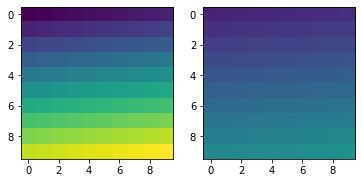

In [8]:
arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('viridis')
new_cmap = truncate_colormap(cmap, 0.1, 0.5)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [9]:
def genScatterPlot(cord_XYZ_Set, path, prefix, title, rotationArray, alpha = 0.8, norm = True, dataSliceVals = (0,1)): 
    #Unpack cord values (using .flatten on sliced object)
    xSet, ySet, zSet = cord_XYZ_Set[:,0], cord_XYZ_Set[:,1], cord_XYZ_Set[:,2]
    
    if norm == True: 
        rPos = (xSet**2 + ySet**2 + zSet**2)**(1/2) #Get length of r
        
        xSet = xSet/rPos #Normalize x data
        ySet = ySet/rPos #Normalize y data
        zSet = zSet/rPos #Normalize z data
        
    count = 0
    newLen = len(xSet[dataSliceVals[0]:dataSliceVals[1]]) #Length of the data after slicing with dataSliceVals
    
    colorMapName = 'viridis'
    colorMap = plt.get_cmap(colorMapName) #cmap to use
    new_cmap = truncate_colormap(colorMap, dataSliceVals[0]/newLen,
                                dataSliceVals[1]/newLen, newLen) #New cmap generated from dataSliceVals and colorMap
    
    for i in rotationArray: #Redraw plot and savefig
        fig = plt.figure(figsize = (15,15))
        axSV_MV = fig.add_subplot(111, projection='3d')
        
        sc = axSV_MV.scatter(xSet[dataSliceVals[0]:dataSliceVals[1]], ySet[dataSliceVals[0]:dataSliceVals[1]], zSet[dataSliceVals[0]:dataSliceVals[1]], 
                             c = np.linspace(dataSliceVals[0], dataSliceVals[1], newLen), cmap = new_cmap, s = 60, edgecolors = 'black', alpha = alpha)
        
        axSV_MV.view_init(elev=0, azim=i) #Change view parameters (spin along the azimuth)
        
        axSV_MV.set_xlabel('x', fontsize = 15) #Assign label
        axSV_MV.set_ylabel('y', fontsize = 15) #Assign label
        axSV_MV.set_zlabel('z', fontsize = 15) #Assign label
        
        axSV_MV.set_title(title, y=0.95, fontsize=15)
        
        figNorm = mpl.colors.Normalize(t[0],t[-1]) # map time data to colorbar (https://bit.ly/3lnV0VR)
        cBar = fig.colorbar(plt.cm.ScalarMappable(norm = figNorm, cmap = colorMapName), ax = axSV_MV, shrink=0.5) #Add color bar to axes = axSV_MV
        cBar.set_label('Time(s)', fontsize = 15)
        
        i_str = str(count)
        suffix = i_str.rjust(4,'0')
        fig.savefig(path + prefix + suffix + '.jpeg')
        fig.clear()
        plt.close(fig)
        count += 1
    
    return(axSV_MV)

In [10]:
def maxStrainScatterPlot(prefix, path, title, rotationArray = np.arange(0,90,1), polarization = 0, dataStepThrough = 10, numberVerts = 100j, norm = True, 
                         dataSlice = (0,1), cenDiffYN = False):
    iterStartMV = 0 #Iteration start
    iterEndMV = len(t) #Iteration end
    iterStepMV = 10 #Iteration step
    nVertsMV = numberVerts #n^(1/2) verts in spherical space

    iterRangeMV = np.arange(iterStartMV,iterEndMV,iterStepMV) #Create iter array

    timeIt = t[iterRangeMV] #Sampled time
    
    sV_X, sV_Y, sV_Z, sV_R = strain3DSurfMaxValue(iterRangeMV, iterStepMV, nVertsMV, polarization = polarization, cenDiffYN = cenDiffYN) #sV_# -> strain value array (X,Y,Z,R)

    sV_R_Pos = np.array([]) #Initialize empty array

    sV_X_Flat = sV_X.reshape((len(sV_X),len(sV_X[0])**2)) #Flatten cord array to 2d array 
    sV_Y_Flat = sV_Y.reshape((len(sV_Y),len(sV_Y[0])**2)) #Flatten cord array to 2d array 
    sV_Z_Flat = sV_Z.reshape((len(sV_Z),len(sV_Z[0])**2)) #Flatten cord array to 2d array 
    sV_R_Flat = sV_R.reshape((len(sV_R),len(sV_R[0])**2)) #Flatten radius array to 2d array 

    sV_R_Pos = np.argmax(sV_R_Flat,axis=1) #Get max R value at each time

    sV_X_MV = np.take_along_axis(sV_X_Flat, np.expand_dims(sV_R_Pos, axis=1),axis=1) #Get values associated with max R values at each time
    sV_Y_MV = np.take_along_axis(sV_Y_Flat, np.expand_dims(sV_R_Pos, axis=1),axis=1) #Get values associated with max R values at each time
    sV_Z_MV = np.take_along_axis(sV_Z_Flat, np.expand_dims(sV_R_Pos, axis=1),axis=1) #Get values associated with max R values at each time

    sV_XYZ_MV = hstack((sV_X_MV,sV_Y_MV,sV_Z_MV)) #Stack cord arrays 

    dataSliceStart = int(np.where(timeIt == timeIt[(timeIt >= dataSlice[0]) & (timeIt <= dataSlice[1])][0])[0]) #Get slice parameters from dataSlice
    dataSliceEnd = int(np.where(timeIt == timeIt[(timeIt >= dataSlice[0]) & (timeIt <= dataSlice[1])][-1])[0]) #Get slice parameters from dataSlice
    
    #print('xyz coords:', sV_XYZ_MV[dataSliceStart:dataSliceEnd])

    genScatterPlot(sV_XYZ_MV, path, prefix, title, rotationArray, norm = norm, dataSliceVals = (dataSliceStart, dataSliceEnd)) #Generate 3D scatter plot

    return()

In [11]:
#Data read info
path = r'C:\Users\crazy\PajkosResearch\RawDataFiles'

fNames_mensa20 = np.array(['mesa20_LR.dat','mesa20_pert.dat','mesa20_pert_LR.dat','mesa20_v_LR.dat','mesa20b.dat'])
fNames_s40 = np.array(['s40_3d_fr.dat','s40_3d_nor.dat','s40_3d_sr.dat'])

colUse = [0, 45, 47, 46, 48, 49, 50] #Coloumns where data is read from (for mesa20 data)
colUse_s40 = [0, 49, 50, 51, 52, 53, 54] #Coloumns where data is read from (for s40 data)

polarizationA = np.array(['cross-polarized','plus-polarized','normDiff-polarized']) #Polarization of the data

rA = np.arange(0,360,2) #Rotation array (start,end,step) (degrees)

polarPC = 1 #Polarization (0 = cross, 1 = plus)

## Mesa20_pert.dat Work

t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, fNames_mensa20[1], colUse)

polarPC = 0 #Polarization (0 = cross, 1 = plus)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[1][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_cross_','AnimationRotateScatter/mesa20_pert_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_cross_%04d.jpeg 3DScatter_mesa20_pert_cross_Movie.mp4

polarPC = 1 #Polarization (0 = cross, 1 = plus)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[1][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_plus_','AnimationRotateScatter/mesa20_pert_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_plus_%04d.jpeg 3DScatter_mesa20_pert_plus_Movie.mp4

## Mesa20_LR.dat Work

In [ ]:
t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, fNames_mensa20[0], colUse)

In [ ]:
polarPC = 0 #Polarization (0 = cross, 1 = plus)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[0][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_cross_','AnimationRotateScatter/mesa20_LR_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_cross_%04d.jpeg 3DScatter_mesa20_LR_cross_Movie.mp4

In [ ]:
polarPC = 1 #Polarization (0 = cross, 1 = plus)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[0][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_plus_','AnimationRotateScatter/mesa20_LR_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_plus_%04d.jpeg 3DScatter_mesa20_LR_plus_Movie.mp4

## Mesa20_pert_LR.dat Work

t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, fNames_mensa20[2], colUse)

polarPC = 0 #Polarization (0 = cross, 1 = plus)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[2][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_cross_','AnimationRotateScatter/mesa20_pert_LR_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_cross_%04d.jpeg 3DScatter_mesa20_pert_LR_cross_Movie.mp4

polarPC = 1 #Polarization (0 = cross, 1 = plus)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[2][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_plus_','AnimationRotateScatter/mesa20_pert_LR_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_plus_%04d.jpeg 3DScatter_mesa20_pert_LR_plus_Movie.mp4

## Mesa20_v_LR.dat Work

t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, fNames_mensa20[3], colUse)

polarPC = 0 #Polarization (0 = cross, 1 = plus)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[3][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_cross_','AnimationRotateScatter/mesa20_v_LR_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_cross_%04d.jpeg 3DScatter_mesa20_v_LR_cross_Movie.mp4

polarPC = 1 #Polarization (0 = cross, 1 = plus)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[3][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_plus_','AnimationRotateScatter/mesa20_v_LR_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_plus_%04d.jpeg 3DScatter_mesa20_v_LR_plus_Movie.mp4

## Mesa20_20b.dat

t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, fNames_mensa20[4], colUse)

polarPC = 0 #Polarization (0 = cross, 1 = plus, 2 = normDiff)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[4][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_cross_','AnimationRotateScatter/mesa20_20b_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_cross_%04d.jpeg 3DScatter_mesa20_20b_cross_Movie.mp4

polarPC = 1 #Polarization (0 = cross, 1 = plus, 2 = normDiff)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[4][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_plus_','AnimationRotateScatter/mesa20_20b_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_plus_%04d.jpeg 3DScatter_mesa20_20b_plus_Movie.mp4

## s40_3d_fr.dat

In [21]:
t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, fNames_s40[0], colUse_s40)
cenDiffYN = True

In [22]:
polarPC = 0 #Polarization (0 = cross, 1 = plus, 2 = normDiff)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_s40[0][:-3]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_s40_cross_','AnimationRotateScatter/s40_3d_fr_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j, cenDiffYN=cenDiffYN)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_s40_cross_%04d.jpeg 3DScatter_s40_3d_fr_cross_Movie.mp4

<Figure size 432x288 with 0 Axes>

In [23]:
polarPC = 1 #Polarization (0 = cross, 1 = plus, 2 = normDiff)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_s40[0][:-3]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_s40_plus_','AnimationRotateScatter/s40_3d_fr_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_s40_plus_%04d.jpeg 3DScatter_s40_3d_fr_plus_Movie.mp4

<Figure size 432x288 with 0 Axes>

## s40_3d_nor.dat

In [24]:
t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, fNames_s40[1], colUse_s40)
cenDiffYN = True

In [25]:
polarPC = 0 #Polarization (0 = cross, 1 = plus, 2 = normDiff)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_s40[1][:-2]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_s40_cross_','AnimationRotateScatter/s40_3d_nor_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j, cenDiffYN=cenDiffYN)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_s40_cross_%04d.jpeg 3DScatter_s40_3d_nor_cross_Movie.mp4

<Figure size 432x288 with 0 Axes>

In [26]:
polarPC = 1 #Polarization (0 = cross, 1 = plus, 2 = normDiff)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_s40[1][:-2]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_s40_plus_','AnimationRotateScatter/s40_3d_nor_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_s40_plus_%04d.jpeg 3DScatter_s40_3d_nor_plus_Movie.mp4

<Figure size 432x288 with 0 Axes>

## s40_3d_sr

In [27]:
t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, fNames_s40[2], colUse_s40)
cenDiffYN = True

In [28]:
polarPC = 0 #Polarization (0 = cross, 1 = plus, 2 = normDiff)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_s40[2][:-2]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_s40_cross_','AnimationRotateScatter/s40_3d_sr_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j, cenDiffYN=cenDiffYN)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_s40_cross_%04d.jpeg 3DScatter_s40_3d_sr_cross_Movie.mp4

<Figure size 432x288 with 0 Axes>

In [29]:
polarPC = 1 #Polarization (0 = cross, 1 = plus, 2 = normDiff)

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_s40[2][:-2]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_s40_plus_','AnimationRotateScatter/s40_3d_sr_MaxStrain_3dScatter/', blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = 100j)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_s40_plus_%04d.jpeg 3DScatter_s40_3d_sr_plus_Movie.mp4

<Figure size 432x288 with 0 Axes>

## Dipole Direction Plot Work

In [ ]:
def maxStrainDipoleDirectionPlot(iterStepMV = 10, polarization = 0, numberVerts = 100j, norm = False):
    iterStartMV = 0 #Iteration start
    iterEndMV = len(t) #Iteration end
    iterStepMV = iterStepMV #Iteration step
    nVertsMV = numberVerts #n^(1/2) verts in spherical space

    iterRangeMV = np.arange(iterStartMV,iterEndMV,iterStepMV) #Create iter array

    sV_X, sV_Y, sV_Z, sV_R = strain3DSurfMaxValue(iterRangeMV, iterStepMV, nVertsMV, polarization = polarization) #sV_# -> strain value array (X,Y,Z,R)

    sV_R_Pos = np.array([]) #Initialize empty array

    sV_X_Flat = sV_X.reshape((len(sV_X),len(sV_X[0])**2)) #Flatten cord array to 2d array 
    sV_Y_Flat = sV_Y.reshape((len(sV_Y),len(sV_Y[0])**2)) #Flatten cord array to 2d array 
    sV_Z_Flat = sV_Z.reshape((len(sV_Z),len(sV_Z[0])**2)) #Flatten cord array to 2d array 
    sV_R_Flat = sV_R.reshape((len(sV_R),len(sV_R[0])**2)) #Flatten radius array to 2d array 

    sV_R_Pos = np.argmax(sV_R_Flat,axis=1) #Get max R value at each time

    sV_X_MV = np.take_along_axis(sV_X_Flat, np.expand_dims(sV_R_Pos, axis=1),axis=1) #Get values associated with max R values at each time
    sV_Y_MV = np.take_along_axis(sV_Y_Flat, np.expand_dims(sV_R_Pos, axis=1),axis=1) #Get values associated with max R values at each time
    sV_Z_MV = np.take_along_axis(sV_Z_Flat, np.expand_dims(sV_R_Pos, axis=1),axis=1) #Get values associated with max R values at each time

#     sV_XYZ_MV = hstack((sV_X_MV,sV_Y_MV,sV_Z_MV)) #Stack cord arrays 
    
    if norm != False: 
        rPos = (sV_X_MV**2 + sV_Y_MV**2 + sV_Z_MV**2)**(1/2) #Get length of r
        
        sV_X_MV = sV_X_MV/rPos #Normalize x data
        sV_Y_MV = sV_Y_MV/rPos #Normalize y data
        sV_Z_MV = sV_Z_MV/rPos #Normalize z data

    theta = np.arccos(sV_Z_MV/(np.sqrt((sV_X_MV**2)+(sV_Y_MV**2)+(sV_Z_MV**2))))
    phi = np.arctan(sV_Y_MV/sV_X_MV)
    
    return(theta, phi)

## Dipole Direction Fourier Transform Plot Work

In [ ]:
def interpAngles(angle, time, lenVector):
    '''
    Interpolate Angles for frequency sampeling
    Angle: Array of angles
    Time: Array containing data time
    lenVector: Frequency range
    '''
    angleReshape = np.reshape(angle, (len(angle)))
    
    fNew = scp.interpolate.interp1d(time,angleReshape) #Get interpolated angles
    
    times = linspace(time[0], time[-1], int(lenVector)) #Get times that will be used to sample fNew
    
    return(fNew(times))


def noNan(inpArray, conVal = 0):
    '''
    Convert any nan values in an array to 0
    '''
    if np.sum(inpArray)==0:
        return(inpArray)
    
    inpArray[np.isnan(inpArray)] = 0
    
    return(inpArray)


def genSpectOutputs(N, rawTimeData, angle1 = 0, angle2 = 0):
    '''
    Generate spectrogram information for the dipole direction of GW
    N: Frequency range uppler limit ??
    rawTimeData: Raw time data 
    Angle1: Direction data
    Angle2: Direction data (optional)
    
    outputs: (f1, t1, Sxx1, t2, f2, Sxx2)
    '''
    TimeArray = linspace(rawTimeData[0], rawTimeData[-1], int(N)) #Generate an evenly spaced array of times of length N
    freqSample = N/(TimeArray[-1]) #Generate frequency sampling value
    
    f1, t1, Sxx1 = 0, 0, 0
    if np.sum(angle1) != 0:
        angle1 = noNan(angle1) #Convert any nan values in the array angle1 to 0

        angle1Spec = interpAngles(angle1, time, N) #Time dependent angles information (interpolated)
        f1, t1, Sxx1 = signal.spectrogram(angle1Spec, freqSample) #Generate Spectrogram info

    f2, t2, Sxx2 = 0, 0, 0
    if np.sum(angle2) != 0:
        angle2 = noNan(angle2) #Convert any nan values in the array angle2 to 0
        
        angle2Spec = interpAngles(angle2, time, N) #Time dependent angles information (interpolated)
        f2, t2, Sxx2 = signal.spectrogram(angle2Spec, freqSample) #Generate Spectrogram info
    
    return([f1, t1, Sxx1, f2, t2, Sxx2])

In [ ]:
def dipoleDirecPlots(dataTime, dataTheta, dataPhi = 0, N = 0, specYesNo = 0, dataUsed = '', fileName = ''):
    '''
    Generate plots of data to analyse dipole direction of GW
    dataTime: data time component
    dataTheta: data theta component
    dataPhi: data phi component
    dataUsed: Model name data is used from
    '''
    fntSize = 25 #Fontsize for all plots
    legendSize = 25
    
    fig = plt.figure(figsize = (40,20))
    axSV_MV_A1 = fig.add_subplot(411)
    
    axSV_MV_A1.plot(dataTime, dataTheta, c = 'blue', label = r'$\theta$')
    axSV_MV_A1.tick_params(axis='both', which='major', labelsize=fntSize/2)
    axSV_MV_A1.set_title(dataUsed + ' : theta', fontsize = fntSize)
    #axSV_MV_A1.legend(prop = {'size':legendSize})
    axSV_MV_A1.grid()
    
    titleF = 'Fourier Transform of:' + dataUsed
    
    if specYesNo !=0:
        f1, t1, Sxx1 = genSpectOutputs(N, dataTime, angle1 = dataTheta)[:3]
        
        axSV_MV_F1 = fig.add_subplot(412, sharex = axSV_MV_A1)
        
        titleF = 'Spectrogram (' + dataUsed + ' : theta)'
        
        axSV_MV_F1.pcolormesh(t1, f1, Sxx1, shading='gouraud')
        axSV_MV_F1.grid()
        axSV_MV_F1.tick_params(axis='both', which='major', labelsize=fntSize/2)
        axSV_MV_F1.set_ylabel('Frequency [Hz]', fontsize = fntSize)
        axSV_MV_F1.set_xlabel('Time [sec]', fontsize = fntSize)
        axSV_MV_F1.set_title(titleF, fontsize = fntSize)
        axSV_MV_F1.set_ylim(0,3500)
        
    if dataPhi.any() != 0:
        
        if specYesNo == 0:
            axSV_MV_A2 = fig.add_subplot(412)
            
        else:
            axSV_MV_A2 = fig.add_subplot(413)
        
        axSV_MV_A2.plot(dataTime, dataPhi, c = 'red', label = '$\phi$')
        axSV_MV_A2.tick_params(axis='both', which='major', labelsize=fntSize/2)
        axSV_MV_A2.set_title(dataUsed + ' : phi', fontsize = fntSize)
        #axSV_MV_A2.legend(prop = {'size':legendSize})
        axSV_MV_A2.grid()
        
        if specYesNo != 0:
            f2, t2, Sxx2 = genSpectOutputs(N, dataTime, angle2 = dataPhi)[3:]
            
            axSV_MV_F2 = fig.add_subplot(414, sharex = axSV_MV_A2)
            
            titleF = 'Spectrogram (' + dataUsed + ' : phi)'
            
            axSV_MV_F2.pcolormesh(t2, f2, Sxx2, shading='gouraud')
            axSV_MV_F2.grid()
            axSV_MV_F2.tick_params(axis='both', which='major', labelsize=fntSize/2)
            axSV_MV_F2.set_ylabel('Frequency [Hz]', fontsize = fntSize)
            axSV_MV_F2.set_xlabel('Time [sec]', fontsize = fntSize)
            axSV_MV_F2.set_title(titleF, fontsize = fntSize)
            axSV_MV_F2.set_ylim(0,3500)
        
    fig.tight_layout()

    path = r'C:\Users\crazy\PajkosResearch\DipoleSpectrograms'
    
    fig.savefig(path + fileName + '.jpeg')
    
    return()

In [ ]:
#Data read info
path = r'C:\Users\crazy\PajkosResearch\RawDataFiles'

fNames_mensa20 = np.array(['mesa20_LR.dat','mesa20_pert.dat','mesa20_pert_LR.dat','mesa20_v_LR.dat','mesa20b.dat'])
fNames_s40 = np.array(['s40_3d_fr.dat','s40_3d_nor.dat','s40_3d_sr.dat'])

colUse = [0, 45, 47, 46, 48, 49, 50] #Coloumns where data is read from (for mesa20 data)
colUse_s40 = [0, 49, 50, 51, 52, 53, 54] #Coloumns where data is read from (for s40 data)

polarizationA = np.array(['cross-polarized','plus-polarized','normDiff-polarized']) #Polarization of the data

rA = np.arange(0,360,2) #Rotation array (start,end,step) (degrees)

polarPC = 1 #Polarization (0 = cross, 1 = plus)

N = 13e3 #Sampled points

yNSpecs = 1 #Produce spectrograms? 1 = yes, !1 = no

### mesa20_LR.dat Dipole Work

In [ ]:
dataUsed = fNames_mensa20[0]
tD_Step = 5 #TimeData_Step for which the data is iterated through

t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, dataUsed, colUse)
theta, phi = maxStrainDipoleDirectionPlot(iterStepMV = tD_Step,norm = True)
time = t[0:-1:tD_Step]

In [ ]:
pathFileDip = '\Imgs_' + dataUsed + '\Img_' + dataUsed 

dipoleDirecPlots(time, theta, phi, N, yNSpecs, dataUsed, pathFileDip)
dipoleDirecPlots(time, np.cos(theta), np.cos(phi), N, yNSpecs, 'cos : ' + dataUsed, pathFileDip + '_cos')
dipoleDirecPlots(time, np.sin(theta), np.sin(phi), N, yNSpecs, 'sin : ' + dataUsed, pathFileDip + '_sin')

## mesa20_pert.dat Dipole Work

In [ ]:
dataUsed = fNames_mensa20[1]
tD_Step = 10 #TimeData_Step for which the data is iterated through

t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, dataUsed, colUse)
theta, phi = maxStrainDipoleDirectionPlot(iterStepMV = tD_Step,norm = True)
time = t[0:-1:tD_Step]

In [ ]:
pathFileDip = '\Imgs_' + dataUsed + '\Img_' + dataUsed 

dipoleDirecPlots(time, theta, phi, N, yNSpecs, dataUsed, pathFileDip)
dipoleDirecPlots(time, np.cos(theta), np.cos(phi), N, yNSpecs, 'cos : ' + dataUsed, pathFileDip + '_cos')
dipoleDirecPlots(time, np.sin(theta), np.sin(phi), N, yNSpecs, 'sin : ' + dataUsed, pathFileDip + '_sin')

### mesa20_pert_LR.dat Dipole Work

In [ ]:
dataUsed = fNames_mensa20[2]
tD_Step = 10 #TimeData_Step for which the data is iterated through

t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, dataUsed, colUse)
theta, phi = maxStrainDipoleDirectionPlot(iterStepMV = tD_Step,norm = True)
time = t[0:-1:tD_Step]

In [ ]:
pathFileDip = '\Imgs_' + dataUsed + '\Img_' + dataUsed 

dipoleDirecPlots(time, theta, phi, N, yNSpecs, dataUsed, pathFileDip)
dipoleDirecPlots(time, np.cos(theta), np.cos(phi), N, yNSpecs, 'cos : ' + dataUsed, pathFileDip + '_cos')
dipoleDirecPlots(time, np.sin(theta), np.sin(phi), N, yNSpecs, 'sin : ' + dataUsed, pathFileDip + '_sin')

### mesa20_v_LR.dat Dipole Work

In [ ]:
dataUsed = fNames_mensa20[3]
tD_Step = 10 #TimeData_Step for which the data is iterated through

t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, dataUsed, colUse)
theta, phi = maxStrainDipoleDirectionPlot(iterStepMV = tD_Step,norm = True)
time = t[0:-1:tD_Step]

In [ ]:
pathFileDip = '\Imgs_' + dataUsed + '\Img_' + dataUsed 

dipoleDirecPlots(time, theta, phi, N, yNSpecs, dataUsed, pathFileDip)
dipoleDirecPlots(time, np.cos(theta), np.cos(phi), N, yNSpecs, 'cos : ' + dataUsed, pathFileDip + '_cos')
dipoleDirecPlots(time, np.sin(theta), np.sin(phi), N, yNSpecs, 'sin : ' + dataUsed, pathFileDip + '_sin')

### mesa20b.dat Dipole Work

In [ ]:
dataUsed = fNames_mensa20[4]
tD_Step = 10 #TimeData_Step for which the data is iterated through

t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, dataUsed, colUse)
theta, phi = maxStrainDipoleDirectionPlot(iterStepMV = tD_Step,norm = True)
time = t[0:-1:tD_Step]

In [ ]:
pathFileDip = '\Imgs_' + dataUsed + '\Img_' + dataUsed 

dipoleDirecPlots(time, theta, phi, N, yNSpecs, dataUsed, pathFileDip)
dipoleDirecPlots(time, np.cos(theta), np.cos(phi), N, yNSpecs, 'cos : ' + dataUsed, pathFileDip + '_cos')
dipoleDirecPlots(time, np.sin(theta), np.sin(phi), N, yNSpecs, 'sin : ' + dataUsed, pathFileDip + '_sin')

## Mesa20_LR.dat Normalized Difference Work

In [ ]:
#Data read info
#Data read info
path = r'C:\Users\crazy\PajkosResearch\RawDataFiles'

fNames_mensa20 = np.array(['mesa20_LR.dat','mesa20_pert.dat','mesa20_pert_LR.dat','mesa20_v_LR.dat','mesa20b.dat'])
fNames_s40 = np.array(['s40_3d_fr.dat','s40_3d_nor.dat','s40_3d_sr.dat'])

colUse = [0, 45, 47, 46, 48, 49, 50] #Coloumns where data is read from (for mesa20 data)
colUse_s40 = [0, 49, 50, 51, 52, 53, 54] #Coloumns where data is read from (for s40 data)

polarizationA = np.array(['cross-polarized','plus-polarized','normDiff-polarized']) #Polarization of the data

rA = np.arange(0,360,2) #Rotation array (start,end,step) (degrees)

polarPC = 1 #Polarization (0 = cross, 1 = plus)

In [ ]:
t,Qxx,Qyy,Qxy,Qxz,Qyz,Qzz = loadDatQ(path, fNames_mensa20[0], colUse)

In [ ]:
polarPC = 2 #Polarization (0 = cross, 1 = plus, 2 = normDiff)
nVertices = 100j
nTF = True #Normalize the xyz coordinates
dSlice = (0.1,0.3) #Times to slice over

blockTitle = 'Normalized, Maximum Gravitational Wave Strain (Data: '+fNames_mensa20[0][:-4]+') ('+polarizationA[polarPC]+')'
maxStrainScatterPlot('3DScatter_mesa20_normDiff_','AnimationRotateScatter/mesa20_LR_MaxStrain_NormDiff_3dScatter/',
                     blockTitle, rotationArray = rA, polarization = polarPC, numberVerts = nVertices, norm = nTF, 
                     dataSlice = dSlice)
plt.clf()

#ffmpeg -framerate 10 -i 3DScatter_mesa20_normDiff_%04d.jpeg 3DScatter_mesa20_LR_normDiff_Movie.mp4

In [ ]:
dataSlice = (0.1,0.2)
print(int(np.where(t == t[(t >= dataSlice[0]) & (t <= dataSlice[1])][0])[0]))
print(int(np.where(t == t[(t >= dataSlice[0]) & (t <= dataSlice[1])][-1])[0]))